In [1]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
np.random.seed(0)

In [3]:
# 構造方程式の設定

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f_X1(sample_size):
    return np.random.binomial(1, 0.5, sample_size)

def f_X2(sample_size):
    return np.random.normal(0, 1, sample_size)

def f_X3(X1, X2, sample_size):
    p = sigmoid(-0.3+0.9*X1-11.2*X2)
    return np.random.binomial(1, p, sample_size)

def f_T(X1, X2, sample_size):
    p = sigmoid(-0.5+1.2*X1+0.8*X2)
    return np.random.binomial(1, p, sample_size)

def f_X4(T, X3, sample_size):
    return 3 + 2.5*T + 3*X3 + np.random.normal(0, np.sqrt(1.5), sample_size)

def f_X5(X4, sample_size):
    return 100 + 10*X4 + np.random.normal(0, np.sqrt(20), sample_size)

def f_Y(X1, X3, X5, sample_size):
    return 1000 + 100*X1 + 500*X3 + 15*X5 + np.random.normal(0, np.sqrt(100), sample_size)

In [4]:
# データの生成

sample_size = 100
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = f_T(X1, X2, sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [5]:
# T=0と介入した場合のデータの生成

sample_size = 10000
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = np.zeros(sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [6]:
# T=1と介入した場合のデータの生成

sample_size = 10000
X1 = f_X1(sample_size)
X2 = f_X2(sample_size)
X3 = f_X3(X1, X2, sample_size)
T = np.ones(sample_size)
X4 = f_X4(T, X3, sample_size)
X5 = f_X5(X4, sample_size)
Y = f_Y(X1, X3, X5, sample_size)

df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y
})

In [7]:
# 平均因果効果の計算

print('平均因果効果:', df_1['Y'].mean() - df_0['Y'].mean())

平均因果効果: 373.6709065155528


In [8]:
# 周辺分布・条件付き分布の推定

# p(x1)の推定
p_x1 = df['X1'].mean()

# p(x2)の推定
mu_x2 = df['X2'].mean()
sigma_x2 = df['X2'].std()

# p(x3|x1,x2)の推定
logisitic_model_x3 = LogisticRegression()
logisitic_model_x3.fit(df[['X1', 'X2']].values, df['X3'].values)

# p(t|x1,x2)の推定
logisitic_model_t = LogisticRegression()
logisitic_model_t.fit(df[['X1', 'X2']].values, df['T'].values)

# p(x4|t,x3)の推定
linear_model_x4 = LinearRegression(fit_intercept=True)
linear_model_x4.fit(df[['T', 'X3']].values, df['X4'].values)
sigma_x4 = np.sqrt(((df['X4'].values - linear_model_x4.predict(df[['T', 'X3']].values)) ** 2).mean())

# p(x5|x4)の推定
linear_model_x5 = LinearRegression(fit_intercept=True)
linear_model_x5.fit(df[['X4']].values, df['X5'].values)
sigma_x5 = np.sqrt(((df['X5'].values - linear_model_x5.predict(df[['X4']].values)) ** 2).mean())

# p(y|x1,x3,x5)の推定
linear_model_y = LinearRegression(fit_intercept=True)
linear_model_y.fit(df[['X1', 'X3', 'X5']].values, df['Y'].values)
sigma_y = np.sqrt(((df['Y'].values - linear_model_y.predict(df[['X1', 'X3', 'X5']].values)) ** 2).mean())

In [9]:
# 推定した分布での平均因果効果の計算

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
p_X3 = logisitic_model_x3.predict_proba(np.c_[X1, X2])[:, 1]
X3 = np.random.binomial(1, p_X3, 10000)
T = np.zeros(10000)
X4 = np.random.normal(linear_model_x4.predict(np.c_[T, X3]), sigma_x4, 10000)
X5 = np.random.normal(linear_model_x5.predict(np.c_[X4]), sigma_x5, 10000)
Y_0 = linear_model_y.predict(np.c_[X1, X3, X5])

hat_df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y_0
})

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
p_X3 = logisitic_model_x3.predict_proba(np.c_[X1, X2])[:, 1]
X3 = np.random.binomial(1, p_X3, 10000)
T = np.ones(10000)
X4 = np.random.normal(linear_model_x4.predict(np.c_[T, X3]), sigma_x4, 10000)
X5 = np.random.normal(linear_model_x5.predict(np.c_[X4]), sigma_x5, 10000)
Y_1 = linear_model_y.predict(np.c_[X1, X3, X5])

hat_df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'T': T,
    'X4': X4,
    'X5': X5,
    'Y': Y_1
})

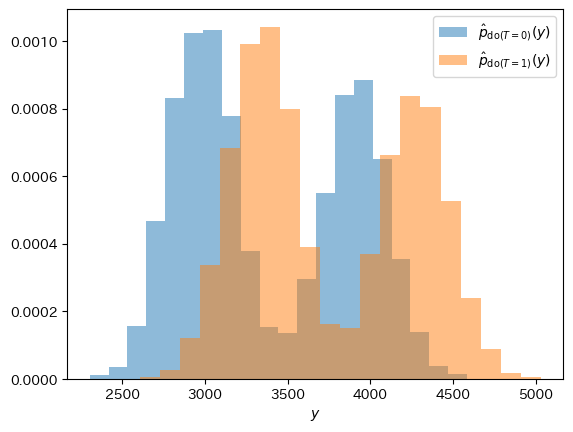

In [13]:
# \hat{p}_{do(T=0)}(y)と\hat{p}_{do(T=1)}(y)の描画

plt.hist(hat_df_0['Y'], bins=20, alpha=0.5, density=True, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y)$')
plt.hist(hat_df_1['Y'], bins=20, alpha=0.5, density=True, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y)$')
plt.legend()
plt.xlabel(r'$y$')
plt.show();

In [14]:
# 平均因果効果の推定値

print('平均因果効果の推定値:', hat_df_1['Y'].mean() - hat_df_0['Y'].mean())

平均因果効果の推定値: 367.47836906849807


In [15]:
# p(y|t, x1, x2)の推定

linear_model_y_t_x1_x2 = LinearRegression(fit_intercept=True)
linear_model_y_t_x1_x2.fit(df[['T', 'X1', 'X2']].values, df['Y'].values)
sigma_y_t_x1_x2 = np.sqrt(((df['Y'].values - linear_model_y_t_x1_x2.predict(df[['T', 'X1', 'X2']].values)) ** 2).mean())

In [16]:
# 推定した分布での平均因果効果の計算

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
T = np.zeros(10000)
Y_0 = np.random.normal(linear_model_y_t_x1_x2.predict(np.c_[T, X1, X2]), sigma_y_t_x1_x2, 10000)

hat_df_0 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'Y': Y_0
})

X1 = np.random.binomial(1, p_x1, 10000)
X2 = np.random.normal(mu_x2, sigma_x2, 10000)
T = np.ones(10000)
Y_1 = np.random.normal(linear_model_y_t_x1_x2.predict(np.c_[T, X1, X2]), sigma_y_t_x1_x2, 10000)

hat_df_1 = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'Y': Y_1
})

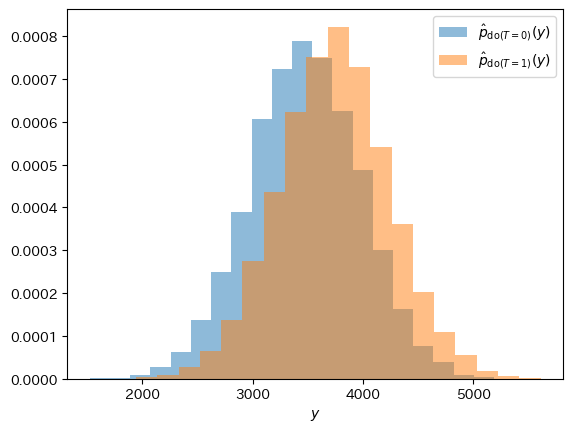

In [17]:
# \hat{p}_{do(T=0)}(y)と\hat{p}_{do(T=1)}(y)の描画

plt.hist(hat_df_0['Y'], bins=20, alpha=0.5, density=True, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y)$')
plt.hist(hat_df_1['Y'], bins=20, alpha=0.5, density=True, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y)$')
plt.legend()
plt.xlabel(r'$y$')
plt.show();

In [18]:
# 平均因果効果の推定値

print('平均因果効果の推定値:', hat_df_1['Y'].mean() - hat_df_0['Y'].mean())

平均因果効果の推定値: 261.9917017529551


In [19]:
# p(y|t, x1, x3)の推定

linear_model_y_t_x1_x3 = LinearRegression(fit_intercept=True)
linear_model_y_t_x1_x3.fit(df[['T', 'X1', 'X3']].values, df['Y'].values)
sigma_y_t_x1_x3 = np.sqrt(((df['Y'].values - linear_model_y_t_x1_x3.predict(df[['T', 'X1', 'X3']].values)) ** 2).mean())

# p(x1, x3)の推定
p_x1_x3_00 = len(df[(df['X1'] == 0) & (df['X3'] == 0)]) / len(df)
p_x1_x3_01 = len(df[(df['X1'] == 0) & (df['X3'] == 1)]) / len(df)
p_x1_x3_10 = len(df[(df['X1'] == 1) & (df['X3'] == 0)]) / len(df)
p_x1_x3_11 = len(df[(df['X1'] == 1) & (df['X3'] == 1)]) / len(df)

In [20]:
def sample_X1_X3(p_00, p_01, p_10, p_11, size=1):
    """
    与えられた確率 p_00, p_01, p_10, p_11 に従って (X1, X3) をサンプリングし、Pandas DataFrame に格納
    
    :param p_00: P(X1=0, X3=0)
    :param p_01: P(X1=0, X3=1)
    :param p_10: P(X1=1, X3=0)
    :param p_11: P(X1=1, X3=1)
    :param size: 生成するサンプル数
    :return: Pandas DataFrame (カラム名: 'X1', 'X3')
    """
    # 確率分布の累積分布関数 (CDF) を作成
    probs = np.array([p_00, p_01, p_10, p_11])
    cdf = np.cumsum(probs)  # CDFを計算

    # 一様乱数を生成
    U = np.random.rand(size)

    # CDF に基づいて (X1, X3) を選択
    X1 = np.select([U < cdf[0], 
                    (U >= cdf[0]) & (U < cdf[1]), 
                    (U >= cdf[1]) & (U < cdf[2])], 
                   [0, 0, 1], default=1)

    X3 = np.select([U < cdf[0], 
                    (U >= cdf[0]) & (U < cdf[1]), 
                    (U >= cdf[2])], 
                   [0, 1, 1], default=0)
    
    # DataFrame に格納
    df = pd.DataFrame({'X1': X1, 'X3': X3})
    return df


In [21]:
# 推定した分布での平均因果効果の計算

X1X3 = sample_X1_X3(p_x1_x3_00, p_x1_x3_01, p_x1_x3_10, p_x1_x3_11, 10000)
T = np.zeros(10000)
Y_0 = np.random.normal(linear_model_y_t_x1_x3.predict(np.c_[T, X1X3]), sigma_y_t_x1_x3, 10000)

hat_df_0 = pd.DataFrame({
    'X1': X1X3['X1'],
    'X3': X1X3['X3'],
    'T': T,
    'Y': Y_0
})

X1X3 = sample_X1_X3(p_x1_x3_00, p_x1_x3_01, p_x1_x3_10, p_x1_x3_11, 10000)
T = np.ones(10000)
Y_1 = np.random.normal(linear_model_y_t_x1_x3.predict(np.c_[T, X1X3]), sigma_y_t_x1_x3, 10000)

hat_df_1 = pd.DataFrame({
    'X1': X1X3['X1'],
    'X3': X1X3['X3'],
    'T': T,
    'Y': Y_1
})

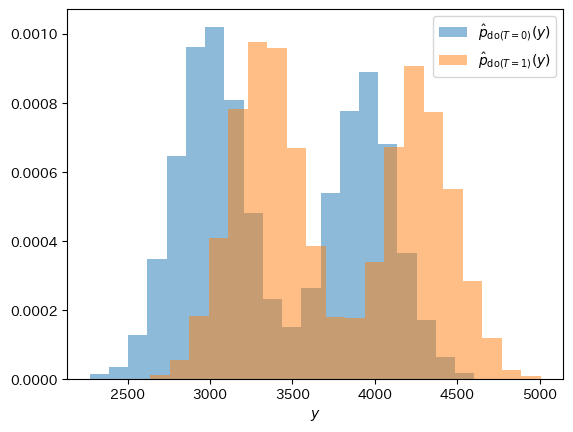

In [22]:
# \hat{p}_{do(T=0)}(y)と\hat{p}_{do(T=1)}(y)の描画

plt.hist(hat_df_0['Y'], bins=20, alpha=0.5, density=True, label=r'$\hat{p}_{\mathrm{do}(T=0)}(y)$')
plt.hist(hat_df_1['Y'], bins=20, alpha=0.5, density=True, label=r'$\hat{p}_{\mathrm{do}(T=1)}(y)$')
plt.legend()
plt.xlabel(r'$y$')
plt.show();

In [23]:
# 平均因果効果の推定値

print('平均因果効果の推定値:', hat_df_1['Y'].mean() - hat_df_0['Y'].mean())

平均因果効果の推定値: 346.01036831831607
